In [1]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import pylibjpeg
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from utils.dcm_utils import *
from utils.nii_utils import *
from utils.train_utils import *

from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF

In [3]:
DATA_DIR = "/media/longyi/SSD9701/"
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, "train_images")
XRAY_IMAGES_DIR = os.path.join(DATA_DIR, "xray_images")
SEG_IMAGES_DIR = os.path.join(DATA_DIR, "segmentation_images")

### Transform

In [4]:
class DataTransform(nn.Module):
    def __init__(self):
        super().__init__()

        self.transform = T.Compose([
            T.Resize(256),
            T.RandomAutocontrast(),
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])

        self.target_transform = T.Compose([
            T.Resize(256),
            T.ToTensor(),
        ])

    def forward(self, x, y):
        x = self.transform(x)

        y = self.target_transform(y)
        y = y.gt(0).float()

        return x, y

transform = DataTransform()

In [5]:
import torchvision.models as models


def resnet18_gray():
    model = models.resnet18(pretrained=True)
    conv1_weight = model.conv1.weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    model.conv1.weight = nn.Parameter(conv1_weight, requires_grad=True)

    return model


class DetectionModel(nn.Module):
    def __init__(self, backbone, channels, deep=4, out_channels=64, n_features=1):
        super().__init__()

        self.backbone = backbone
        self.deep = deep
        self.channels = channels
        self.out_channels = out_channels
        self.n_features = n_features

        self.init_layers()

    def init_layers(self):
        self.parallel_modules = self.make_parallel_modules()
        self.upsampling_modules = self.make_upsampling_modules()

        self.downsampling_modules = self.make_downsampling_modules()
        self.classification_modules = self.make_classification_modules()

    def make_classification_modules(self):
        # the last layer
        return nn.Sequential(
            nn.Conv2d(self.out_channels, self.n_features, kernel_size=1),
            #             nn.AdaptiveMaxPool2d(output_size=(None, 1))
        )

    def make_parallel_modules(self):
        parallel_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Conv2d(self.channels[i], self.channels[i], kernel_size=3, padding='same')
            parallel_modules.append(module)

        return parallel_modules

    def make_downsampling_modules(self):
        return nn.ModuleList([
            nn.Sequential(
                self.backbone.conv1,
                self.backbone.bn1,
                self.backbone.relu,
                self.backbone.maxpool),
            nn.Sequential(
                self.backbone.layer1,
                self.backbone.layer2,
            ),

            self.backbone.layer3,
            self.backbone.layer4
        ])

    def make_upsampling_modules(self):
        upsampling_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i], self.channels[i - 1] if i > 0 else self.out_channels, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Upsample(scale_factor=2)
            )
            upsampling_modules.append(module)

        return upsampling_modules

    def forward(self, x):

        downsampling_outputs = []
        out = x
        for module in self.downsampling_modules:
            out = module(out)
            downsampling_outputs.append(out)

        parallel_outputs = []
        for i in range(len(self.parallel_modules)):
            module = self.parallel_modules[i]
            out = module(downsampling_outputs[i])
            parallel_outputs.append(out)

        out = 0
        for i in range(len(self.upsampling_modules)):
            module = self.upsampling_modules[-(i + 1)]
            parallel_output = parallel_outputs[-(i + 1)]

            up_input = out + parallel_output
            out = module(up_input)

        out = self.classification_modules(out)

        return out


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
backbone = resnet18_gray()
model = DetectionModel(backbone, channels=[64, 128, 256, 512], out_channels=64, n_features=1).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

14994345

In [8]:
model.load_state_dict(torch.load('../train/checkpoint/brief_segmentation_detection_231937.pth'))

<All keys matched successfully>

In [ ]:
header = [
    'UID', 'slice',
    'x0','x1','y0','y1'
]
# f = open('tmp_','w',newline='')
# writer = csv.writer(f)
# writer.writerow(header)

In [ ]:
def write_row(pred, slice, UID):
    nonzero = pred.cpu().squeeze().nonzero()
    min_values, _ = nonzero.min(dim=0)
    max_values, _ = nonzero.max(dim=0)

    min_row, min_column = min_values[0], min_values[1]
    max_row, max_column = max_values[0], max_values[1]



In [70]:
def inference(model, UID):
    model.eval()

    imgs, image_positions, image_orientations, pixel_spacings, slice_thicknesses, is_flip = read_patient_dcm(os.path.join(TRAIN_IMAGES_DIR, UID))

    imgs = normalize_hu(imgs)

    # x0, x1, y0, y1
    # pos = np.zeros((imgs.shape[0], 4))
    centers = np.zeros((imgs.shape[0], 2))
    for i in tqdm(range(imgs.shape[0])):

        x = Image.fromarray(np.uint8(imgs[i, :, :] * 255), 'L')

        transform = T.Compose([
            T.Resize(256),
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])

        x = transform(x).unsqueeze(0)

        # x, y = torch.stack(x_list), torch.stack(y_list)

        x = x.to(device)
        logits = model(x)
        pred = logits.sigmoid().gt(0.5).float()

        nonzero = pred.cpu().squeeze().nonzero().float()

        if len(nonzero) == 0:
            continue
        centers[i, :] = torch.mean(nonzero, dim=0)
        # min_values, _ = nonzero.min(dim=0)
        # max_values, _ = nonzero.max(dim=0)
        #
        # min_row, min_column = min_values[0], min_values[1]
        # max_row, max_column = max_values[0], max_values[1]
        #
        # pos[i] = [min_column, max_column, min_row, max_row]
        # x = x * 0.5 + 0.5
        #
        # combined = torch.cat((x, pred), dim=-1)
        # torchvision.utils.save_image(combined, f"./tmp/{i}.jpeg")

    return centers * 2
with torch.no_grad():
    centers = inference(model, "1.2.826.0.1.3680043.3882")
centers

total slices 241


100%|██████████| 241/241 [00:01<00:00, 161.32it/s]


array([[169.84210205, 194.47367859],
       [165.        , 185.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
 

In [50]:
pos

array([[180., 206., 160., 182.],
       [184., 186., 164., 166.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  

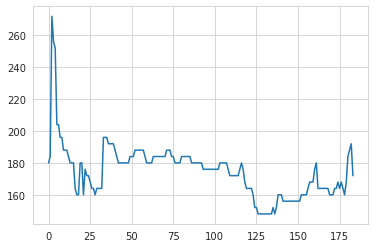

In [51]:
x0 = pos[:, 0]
nonzero_x0 = x0[x0 > 0]
plt.plot(nonzero_x0)

In [52]:
p = np.poly1d(z)
p

poly1d([-0.22348279, 68.97078968])

In [54]:
np.mean(nonzero_x0)

174.69565217391303

In [55]:
np.std(nonzero_x0)

16.91522283935698

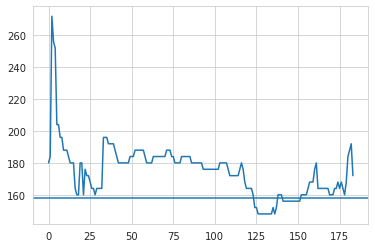

In [56]:
plt.plot(nonzero_x0)
plt.axhline(np.mean(nonzero_x0) - np.std(nonzero_x0))

가운데 80% 에서 가장 작은 수치, 굳이 엄청 정확할 필요는 없다.
이 부분의 데이터의 sagittal 를 C 의 classification 에 쓰겠다.
너무 뭐가 없으면 판단하기 어렵기 때문에 대략 가운데 놓인 sagittal 이미지를 갖고 판단하는게 좋을것 같다.

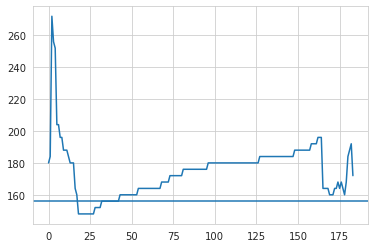

In [62]:
threshold = 0.8
len_nonzero = len(nonzero_x0)
min_nonzero = np.sort(nonzero_x0)[int(len_nonzero * threshold)]
plt.plot(nonzero_x0)
plt.axhline(min_nonzero)

center 가 어느정도인가 보자


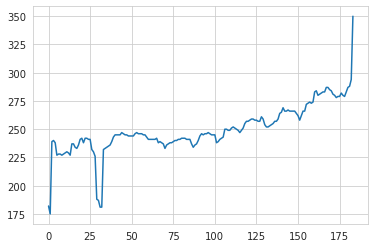

In [64]:
x_center = np.mean(pos, axis=1)
x_center = x_center[x_center > 0]
plt.plot(x_center)